# Introduction To Machine Learning

## Denoising Example

A convolutional neural network that removes random noise from images with a gaussian kernel. 

Created on Tue Nov 19 23:19:17 2019

@author: Lukas Hecker

In [2]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# lh_utils is my own library which I created for the scope of this course:
from lh_utils import get_kernel, shift_kernel, norm_me, add_noise

# Basic Parameters

In [3]:
nsamples = int(1e4) # total number of samples
batch_size = 32 # how many samples are used to calculate the error that is backpropagated
epochs = 50 # One epoch means each sample was propagated through the neural network
input_shape = (32, 32, 1) # dimension of the image
noiselvl = (0.15, 0.50) # lower and upper bound of the proportion of noise.

# Data Generation

Generate Data with gaussian kernels (targets; y_) and add a certain amount of noise to them (inputs, x_).

In [4]:
x = np.zeros(shape=(nsamples, input_shape[0], input_shape[0]))
y = np.zeros(shape=(nsamples, input_shape[0], input_shape[0]))

for i in range(nsamples):
    if i % 1000 == 0 or i==nsamples-1:
        print("{} samples".format(i))
    y_tmp = get_kernel() # Get a 2D matrix displaying some gaussian kernel
    y_shifted = shift_kernel(y_tmp) # Shift that kernel by random amount up/down and left/right
    y[i,] = norm_me(y_shifted) # Normalize to max == 1
    x[i,] = add_noise(y[i,], noiselvl) # Add some amount of noise

# Reshape to have empty color dimension (grey scales)
x = np.expand_dims(x, axis=3)
y = np.expand_dims(y, axis=3)
# Split Data into Training, Validation and Test Set (80 - 10 - 10 %)
x_tr = x[0:int(nsamples*0.8), ]
y_tr = y[0:int(nsamples*0.8), ]

x_val = x[int(nsamples*0.8):int(nsamples*0.9), ]
y_val = y[int(nsamples*0.8):int(nsamples*0.9), ]

x_tst = x[int(nsamples*0.9):, ]
y_tst = y[int(nsamples*0.9):, ]


0 samples
1000 samples
2000 samples
3000 samples
4000 samples
5000 samples
6000 samples
7000 samples
8000 samples
9000 samples
9999 samples


# Visualize some training data

Text(0.5, 1.0, 'Input (Noisy input to ANN)')

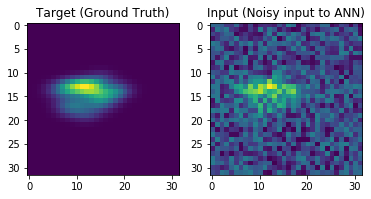

In [6]:
sample = np.random.randint(low=0, high=int(nsamples*0.8))

f, (ax1, ax2) = plt.subplots(1, 2)

im = ax1.imshow(np.squeeze(y_tr[sample,]))
ax1.set_title("Target (Ground Truth)")

im = ax2.imshow(np.squeeze(x_tr[sample,]))
ax2.set_title("Input (Noisy input to ANN)")

# Build Neural Network

This is a pure convolutional neural network (CNN) using of 4 hidden layers of convolutions.

In [7]:
# Build network Architecture using the functional API:
# del x
input_img = Input(shape=input_shape)  # Define the input dimensions
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
out = Conv2D(1, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)

model = Model(input_img, out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 1)         289       
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________

# Loss Function

Implement the loss function. Although all loss functions calculate some error that is minimized during training, they influence the training by large. Always think about what property in the prediction you want to encourage/ penalize and whether your loss function is optimized for it. The mean squared error is a common loss that penalizes high errors more than small errors. The mean absolute error does not have this property.

In [8]:
def mean_squared_error(y_true, y_pred):
    # Computes the mean squared error between prediction and target
    error = y_true - y_pred
    mse = K.mean(K.square(error))
    return mse

def mean_absolute_error(y_true, y_pred):
    # Computes the mean absolute error between prediction and target
    error = y_true - y_pred
    mse = K.mean(K.abs(error))
    return mse



# Train Neural Network

In [9]:
optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)

model.compile(optimizer=optimizer, loss=mean_squared_error)

model.fit(x_tr, y_tr,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, y_val)
                )

Train on 8000 samples, validate on 1000 samples
Epoch 1/50
8000/8000 [==============================] - 5s 592us/sample - loss: 0.0038 - val_loss: 0.0012
Epoch 2/50
8000/8000 [==============================] - 1s 116us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 3/50
8000/8000 [==============================] - 1s 115us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 4/50
8000/8000 [==============================] - 1s 115us/sample - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
8000/8000 [==============================] - 1s 115us/sample - loss: 0.0010 - val_loss: 0.0010
Epoch 6/50
8000/8000 [==============================] - 1s 115us/sample - loss: 0.0010 - val_loss: 0.0010
Epoch 7/50
8000/8000 [==============================] - 1s 115us/sample - loss: 0.0010 - val_loss: 9.9754e-04
Epoch 8/50
8000/8000 [==============================] - 1s 115us/sample - loss: 9.9152e-04 - val_loss: 9.8427e-04
Epoch 9/50
8000/8000 [==============================] - 1s 116us/sample - loss: 9.7985e-04 -

# Evaluate the Model

Predict the Inputs of the testset and compare to the true images for an unbiased evaluation.

In [10]:
score = model.evaluate(x_tst, y_tst, verbose=0)
print('Test loss:', score)


Test loss: 0.0008461075834929943


Visualize some Inputs (x_tst), targets (y_tst) and predictions (p_tst)

In [11]:
p_tst = model.predict(x_tst)

Text(0.5, 1.0, 'Denoised Prediction')

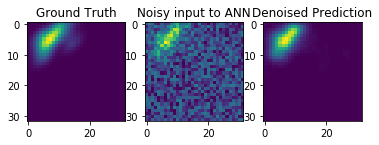

In [17]:
sample = np.random.randint(low=0, high=1000)

f, (ax1, ax2, ax3) = plt.subplots(1, 3)

im = ax1.imshow(np.squeeze(y_tst[sample,]))
# f.colorbar(im, ax=ax1)
ax1.set_title("Ground Truth")

im = ax2.imshow(np.squeeze(x_tst[sample,]))
# f.colorbar(im, ax=ax2)
ax2.set_title("Noisy input to ANN")


im = ax3.imshow(np.squeeze(p_tst[sample,]))
# f.colorbar(im, ax=ax3)
ax3.set_title("Denoised Prediction")
